# Tutorial: How to use ExTrack


In [1]:
import extrack
import numpy as np
from matplotlib import pyplot as plt

version: 0.4.4.8.1


simulate tracks able to come and leave from the field of view :

extrack.simulate_tracks.sim_FOV
inputs:
- nb_tracks: number of tracks simulated.
- max_track_len: number of steps simulated per track.
- LocErr: standard deviation of the localization error.
- Ds: 1D array of the diffusion coefs for each state.
- TrMat: transition array per step (lines: state at time n, cols: states at time n+1).
- dt: time in between frames.
- pBL: probability of bleaching per step.
- cell_dims: dimension limits in x, y and z respectively. x, y dimension limits are useful when tracking membrane proteins in tirf when the particles leave the field of view from the sides of the cells. z dimension is relevant for cytoplasmic proteins which can leave from the z axis. Consider the particle can leave from both ends of each axis: multiply axis limit by 2 to aproximate tracks leaving from one end.
- min_len: minimal track length for the track to be considered.

outputs:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- all_Bs: dict descibing the true states of tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.

In [5]:
dt = 0.025
all_tracks, all_Bs = extrack.simulate_tracks.sim_FOV(nb_tracks=40000,
                                                     max_track_len=60,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     cell_dims = [1,None,None],
                                                     min_len = 20)

number of tracks:
20 pos : 465, 21 pos : 458, 22 pos : 410, 23 pos : 339, 24 pos : 283, 25 pos : 236, 26 pos : 235, 27 pos : 208, 28 pos : 161, 29 pos : 132, 30 pos : 114, 31 pos : 97, 32 pos : 103, 33 pos : 71, 34 pos : 61, 35 pos : 57, 36 pos : 60, 37 pos : 49, 38 pos : 30, 39 pos : 29, 40 pos : 30, 41 pos : 24, 42 pos : 18, 43 pos : 18, 44 pos : 21, 45 pos : 14, 46 pos : 17, 47 pos : 9, 48 pos : 9, 49 pos : 4, 50 pos : 6, 51 pos : 6, 53 pos : 5, 54 pos : 2, 55 pos : 2, 56 pos : 2, 57 pos : 2, 58 pos : 1, 59 pos : 3, 60 pos : 8, 

fitting the parameters to the data set:

extrack.tracking.get_2DSPT_params
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- dt: time in between frames.
- cell_dims: dimension limits (um).
- nb_substeps: number of virtual transition steps in between consecutive 2 positions.
- nb_states: number of states. estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- frame_len: number of frames for which the probability is perfectly computed. See method of the paper for more details.
- verbose: if 1, print the intermediate values for each iteration of the fit.
- steady_state: True if tracks are considered at steady state (fractions independent of time), this is most likely not true as tracks join and leave the FOV.
- vary_params: dict specifying if each parameters should be changed (True) or not (False).
- estimated_vals: initial values of the fit. (stay constant if parameter fixed by vary_params). estimated_vals must be in between min_values and max_values even if fixed.
- min_values: minimal values for the fit.
- max_values: maximal values for the fit.

outputs:
- model_fit: lmfit model

In [13]:
model_fit = extrack.tracking.get_2DSPT_params(all_tracks,
                                              dt,
                                              cell_dims = [1],
                                              nb_substeps = 1,
                                              nb_states = 2,
                                              frame_len = 6,
                                              verbose = 1,
                                              steady_state = False,
                                              vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : False, 'p01' : True, 'p10' : True, 'pBL' : True},
                                              estimated_vals = {'LocErr' : 0.020, 'D0' : 0, 'D1' : 0.5, 'F0' : 0.6, 'p01' : 0.1, 'p10' : 0.1, 'pBL' : 0.1},
                                              min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.01, 'p10' : 0.01, 'pBL' : 0.01},
                                              max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99})

Parameters([('D0', <Parameter 'D0', value=1e-12, bounds=[1e-12:1]>), ('D1_minus_D0', <Parameter 'D1_minus_D0', value=0.5, bounds=[9.999999000000001e-06:10]>), ('D1', <Parameter 'D1', value=0.500000000001, bounds=[-inf:inf], expr='D0 + D1_minus_D0'>), ('LocErr', <Parameter 'LocErr', value=0.02, bounds=[0.007:0.6]>), ('F0', <Parameter 'F0', value=0.6 (fixed), bounds=[0.001:0.999]>), ('p01', <Parameter 'p01', value=0.1, bounds=[0.01:1.0]>), ('p10', <Parameter 'p10', value=0.1, bounds=[0.01:1.0]>), ('pBL', <Parameter 'pBL', value=0.1, bounds=[0.01:0.99]>)])
76080.25126000852 ['D0 = 0.0', 'D1_minus_D0 = 0.5', 'D1 = 0.5', 'LocErr = 0.02', 'F0 = 0.6', 'p01 = 0.1', 'p10 = 0.1', 'pBL = 0.1']
76080.25126000852 ['D0 = 0.0', 'D1_minus_D0 = 0.5', 'D1 = 0.5', 'LocErr = 0.02', 'F0 = 0.6', 'p01 = 0.1', 'p10 = 0.1', 'pBL = 0.1']
45199.70253545236 ['D0 = 0.2298', 'D1_minus_D0 = 0.5', 'D1 = 0.7298', 'LocErr = 0.02', 'F0 = 0.6', 'p01 = 0.1', 'p10 = 0.1', 'pBL = 0.1']
32749.63675343299 ['D0 = 0.5236', 'D1_

76105.32723905181 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0842', 'p10 = 0.1', 'pBL = 0.1']
76106.68664546809 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.088', 'p10 = 0.1', 'pBL = 0.1']
76106.70265671653 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1', 'pBL = 0.1']
76106.70220857805 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0883', 'p10 = 0.1', 'pBL = 0.1']
76106.70124273055 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0886', 'p10 = 0.1', 'pBL = 0.1']
76106.70265671653 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1', 'pBL = 0.1']
74405.42656480566 ['D0 = 0.0', 'D1_minus_D0 = 0.4737', 'D1 = 0.4737', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.5257', 'pBL = 0.1

76123.75147096811 ['D0 = 0.0', 'D1_minus_D0 = 0.4764', 'D1 = 0.4764', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
76123.75146256549 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
76123.7514829676 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
11914.852631990077 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.2238', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
10763.753047894033 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.2297', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
76123.7514829676 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.0201', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0.1208', 'pBL = 0.1']
75929.48165129423 ['D0 = 0.0', 'D1_minus_D0 = 0.4763', 'D1 = 0.4763', 'LocErr = 0.022', 'F0 = 0.6', 'p01 = 0.0885', 'p10 = 0

produces histograms of time spent in each state :

extrack.visualization.visualize_states_durations
inputs:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- params: lmfit parameters used for the model.
- dt: time in between frames.
- cell_dims: dimension limits (um). estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- max_nb_states: maximum number of sequences kept (most likely sequences).
- nb_steps_lim: upper limit of the plot in the x axis (number of steps)
- long_tracks: if True only selects tracks longer than nb_steps_lim
- steps: x axis in seconds if False or in number of steps if False.

outputs:
- plot of all tracks (preferencially input a single movie)

........................................state 0: -0.07291096605535452
state 1: -0.17077222445385243


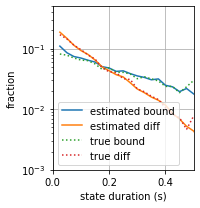

In [7]:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = model_fit.params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = True,
                                                 nb_steps_lim = 20,
                                                 steps = False)

# ground truth histogram (actual labeling from simulations) :

seg_len_hists = extrack.histograms.ground_truth_hist(all_Bs, 2)
plt.plot(np.arange(1,len(seg_len_hists)+1)[:,None]*dt, seg_len_hists/np.sum(seg_len_hists,0), ':')
plt.legend(['estimated bound','estimated diff','true bound','true diff'])
# assesment of the slops of the histograms :

print('state 0:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,0], 1)[0])
print('state 1:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,1], 1)[0])

In [8]:
# if someone wants to run a an analysis with specific values, they can either fixe all parameters of the fit
# or use the following function :

params = extrack.tracking.get_params(nb_states = 2,
                                     steady_state = False,
                                     vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : True, 'p01' : True, 'p10' : True, 'pBL' : True},
                                     estimated_vals = {'LocErr' : 0.025, 'D0' : 1e-20, 'D1' : 0.05, 'F0' : 0.45, 'p01' : 0.05, 'p10' : 0.05, 'pBL' : 0.1},
                                     min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.01, 'p10' : 0.01, 'pBL' : 0.01},
                                     max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99})

states preditions by ExTrack :

extrack.tracking.predict_Bs
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- params: lmfit parameters used for the model.
- dt: time in between frames.
- cell_dims: dimension limits (um). estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- nb_states: number of states. estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- frame_len: number of frames for which the probability is perfectly computed. See method of the paper for more details.

outputs:
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.

In [17]:

# simulation of fiewer tracks to plot them and their annotation infered by ExTrack :

all_tracks, all_Bs = extrack.simulate_tracks.sim_FOV(nb_tracks=500,
                                                     max_track_len=60,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     cell_dims = [1,], # dimension limits in x, y and z respectively
                                                     min_len = 11)

# performs the states probability predictions based on the most likely parameters :

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt,
                                      model_fit.params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=12)


number of tracks:
11 pos : 23, 12 pos : 21, 13 pos : 16, 14 pos : 13, 15 pos : 9, 16 pos : 16, 17 pos : 9, 18 pos : 9, 19 pos : 3, 20 pos : 8, 21 pos : 9, 22 pos : 4, 23 pos : 8, 24 pos : 3, 25 pos : 1, 26 pos : 4, 27 pos : 1, 28 pos : 2, 29 pos : 1, 30 pos : 3, 31 pos : 1, 35 pos : 2, 37 pos : 2, 38 pos : 1, 39 pos : 1, 43 pos : 1, 46 pos : 1, 

turn outputs from extrack to a more classical data frame format :

extrack.exporters.extrack_2_pandas
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- frames: dict describing the frame of each position of each track with keys track length (number of time positions, e.g. '23') of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- opt_metrics: dict of dicts for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. {'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}

outputs:
- DATA: pandas dataframe containing the necessary informations for each track

In [18]:

DATA = extrack.exporters.extrack_2_pandas(all_tracks, pred_Bs, frames = None, opt_metrics = {})


show all tracks on top of each other

extrack.visualization.visualize_tracks
arguments:
- DATA: dataframe outputed by extrack.exporters.extrack_2_pandas
- track_length_range: range of tracks ploted. plotting too many tracks may make it crash
- figsize: size of the figure plotted

171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


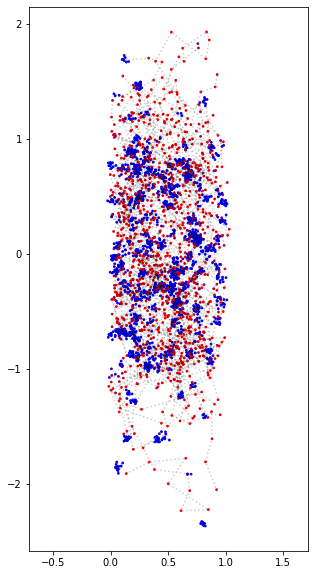

In [19]:
# show all tracks :

extrack.visualization.visualize_tracks(DATA,
                                       track_length_range = [10,np.inf],
                                       figsize = (5,10))

show the longest tracks in more details :
extrack.visualization.plot_tracks

arguments:
- DATA: dataframe outputed by extrack.exporters.extrack_2_pandas.
- max_track_length: maximum track length to be outputed, it will plot the longest tracks respecting this criteria.
- nb_subplots: number of lines and columns of subplots.
- figsize: size of the figure plotted

171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147


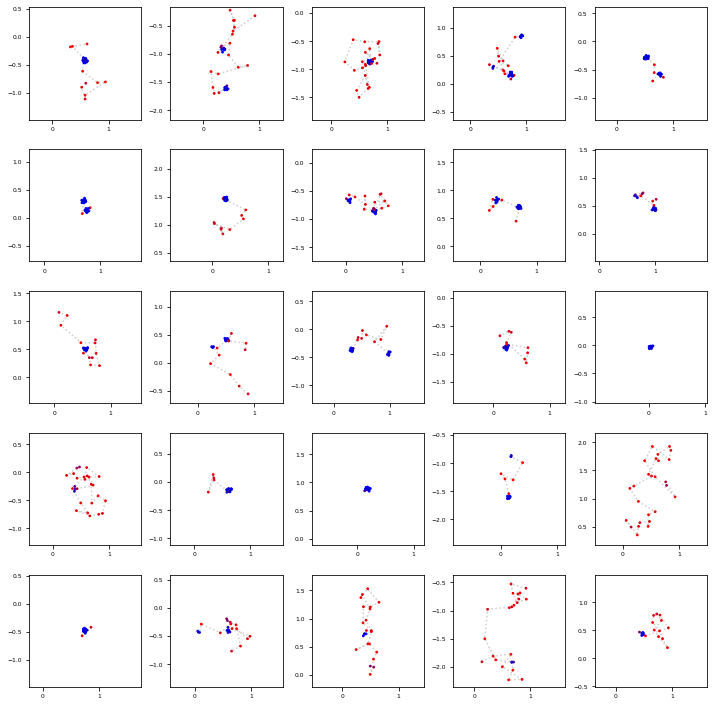

In [20]:
# show the longest tracks in more details :

extrack.visualization.plot_tracks(DATA,
                                  max_track_length = 50,
                                  nb_subplots = [5,5],
                                  figsize = (10,10), 
                                  lim = 1)

save tracks as either xml file used by trackmate or in a CSV file.
extrack.exporters.save_extrack_2_xml
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- params: lmfit parameters
- path: path + name of the saved file
- dt: time in between frames.
- all_frames: dict describing the frame of each position of each track with keys track length (number of time positions, e.g. '23') of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- opt_metrics: dict of dicts for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. {'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}

In [22]:
# save as xml file used for trackmate :

save_path = './tracks.xml' 
extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = model_fit.params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {})

# save as csv file :
save_path = '/home/oem/Downloads/tracks.csv' 
DATA.to_csv(save_path)
